# Tutorial on Variational Quantum Eigensolver (Part IV)
## Inside the *Qiskit* implementation of VQE
---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

During this Tutorial we will use the VQE implementation of Qiskit and investigate what is going on inside. We will use a simple Hamiltonian and problem to explore the VQE. We will use the 'Max-Cut' Problem.


## Import libraries 

We import all necessary functions from IBM qiskit and python **libraries**, that we will later use on this Notebook.


In [1]:
# Packages to define and plot node network.
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

# Import Qiskit libraries
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.INFO)  ##(logging.DEBUG) ##(logging.INFO)  # choose INFO, DEBUG to see the log
#set_qiskit_aqua_logging(logging.DEBUG)

## Definition of Graph and Adjacency Matrix

We will be coloring the nodes in Red and Blue to separate the $x_i=0$ from the $x_i=1$. 


Adjacency Matrix:

[[0. 3. 1. 3. 0.]
 [3. 0. 0. 0. 2.]
 [1. 0. 0. 3. 0.]
 [3. 0. 3. 0. 2.]
 [0. 2. 0. 2. 0.]]

Graph:


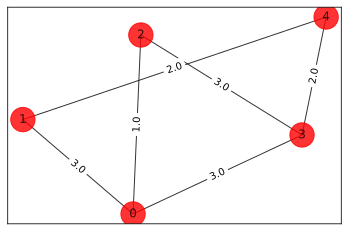

In [2]:
# Generating a graph of 5 nodes

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,3.0),(0,2,1.0),(0,3,3.0),(1,4,2.0),(3,4,2.0),(2,3,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print ("Adjacency Matrix:\n")
print(w)
print ("\nGraph:")


# Classical Approaches
## Brute Force Approach $2^n$ calculations.

Case = [0, 0, 0, 0, 0], cost = 0.0. :: Best Cost=0.0, Best solution = [0, 0, 0, 0, 0]
Case = [1, 0, 0, 0, 0], cost = 7.0. :: Best Cost=7.0, Best solution = [1, 0, 0, 0, 0]
Case = [0, 1, 0, 0, 0], cost = 5.0. :: Best Cost=7.0, Best solution = [1, 0, 0, 0, 0]
Case = [1, 1, 0, 0, 0], cost = 6.0. :: Best Cost=7.0, Best solution = [1, 0, 0, 0, 0]
Case = [0, 0, 1, 0, 0], cost = 4.0. :: Best Cost=7.0, Best solution = [1, 0, 0, 0, 0]
Case = [1, 0, 1, 0, 0], cost = 9.0. :: Best Cost=9.0, Best solution = [1, 0, 1, 0, 0]
Case = [0, 1, 1, 0, 0], cost = 9.0. :: Best Cost=9.0, Best solution = [0, 1, 1, 0, 0]
Case = [1, 1, 1, 0, 0], cost = 8.0. :: Best Cost=9.0, Best solution = [0, 1, 1, 0, 0]
Case = [0, 0, 0, 1, 0], cost = 8.0. :: Best Cost=9.0, Best solution = [0, 1, 1, 0, 0]
Case = [1, 0, 0, 1, 0], cost = 9.0. :: Best Cost=9.0, Best solution = [1, 0, 0, 1, 0]
Case = [0, 1, 0, 1, 0], cost = 13.0. :: Best Cost=13.0, Best solution = [0, 1, 0, 1, 0]
Case = [1, 1, 0, 1, 0], cost = 8.0. :: Best Cost=13.

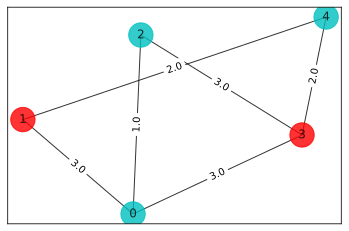

In [3]:
best_cost_brute = 0
#xbest_brute = []
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    #print(list(bin(b)[2:].zfill(n)))
    #print(x)
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute <= cost:
        best_cost_brute = cost
        xbest_brute = x
    print('Case = ' + str(x)+ ', cost = ' + str(cost) + '. :: Best Cost=' + str(best_cost_brute) + ', Best solution = ' + str(xbest_brute))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

## Classical eigensolver for Quadratic Problem with Ising Hamiltonian

Offset: -7.0
Ising Hamiltonian:
IIIZZ	(1.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(1.5+0j)
IZZII	(1.5+0j)
ZIIZI	(1+0j)
ZZIII	(1+0j)


energy: -6.0
max-cut objective: -13.0
solution: [1 0 1 0 1]
solution objective: 13.0


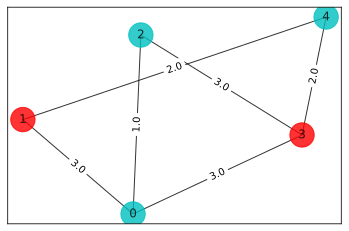

In [4]:
# Create MaxCut Hamiltonian Operator with Qiskit
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

#print (result)

x = sample_most_likely(result.eigenstate)
#print (x)
print('\nenergy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)


# Quantum Approaches
## Quantum Simulation with VQE

In [5]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

2021-01-31 00:50:17,883:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2021-01-31 00:50:17,884:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None


2021-01-31 00:50:18,585:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: <qiskit.aqua.operators.converters.circuit_sampler.CircuitSampler object at 0x000001F11AE0B340>
-- expectation: <qiskit.aqua.operators.expectations.matrix_expectation.MatrixExpectation object at 0x000001F11AE0B3A0>
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  1.5 * IIIZZ,
  0.5 * IIZIZ,
  1.5 * IZIIZ,
  1.5 * IZZII,
  ZIIZI,
  ZZIII
])
-- quantum_instance: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2'

2021-01-31 00:50:18,586:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 2.2915011  -5.60685044 -3.51406148 -3.9663008  -4.07268656  3.92189524
  5.31991014 -2.80764892  4.01815433  4.89953608  0.16299155 -3.20486934
  4.07454007 -3.59696069  3.03436447  1.63287677  5.37095801 -3.36894106
  3.75891723  0.22826859 -3.37337151 -4.19837424 -0.02778464  1.03954849
 -3.96672584]
2021-01-31 00:50:18,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.46875856] - 55.00293 (ms), eval count: 1
2021-01-31 00:50:18,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-01-31 00:50:19,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.40865219] - 4.99845 (ms), eval count: 51
2021-01-31 00:50:19,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.30738685] - 3.99923 (ms), eval count: 52
2021-01-31 00:50:19,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.44333541] - 5.00011 (ms), eval count: 53
2021-01-31 00:50:19,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.64421813] - 5.00154 (ms), eval count: 54
2021-01-31 00:50:19,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.79573743] - 6.03914 (ms), eval count: 55
2021-01-31 00:50:19,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.66361932] - 4.98605 (ms), eval count: 56
2021-01-31 00:50:19,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluatio

2021-01-31 00:50:19,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.23455828] - 5.00083 (ms), eval count: 106
2021-01-31 00:50:19,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09356498] - 4.99916 (ms), eval count: 107
2021-01-31 00:50:19,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.03187712] - 5.02801 (ms), eval count: 108
2021-01-31 00:50:19,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.95017062] - 5.00083 (ms), eval count: 109
2021-01-31 00:50:19,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.67521094] - 4.99821 (ms), eval count: 110
2021-01-31 00:50:19,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.11280564] - 7.00235 (ms), eval count: 111
2021-01-31 00:50:19,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:19,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71522582] - 6.00195 (ms), eval count: 160
2021-01-31 00:50:19,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.66563241] - 5.00250 (ms), eval count: 161
2021-01-31 00:50:19,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71256367] - 4.02737 (ms), eval count: 162
2021-01-31 00:50:19,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56733451] - 5.99647 (ms), eval count: 163
2021-01-31 00:50:19,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69724915] - 5.00202 (ms), eval count: 164
2021-01-31 00:50:19,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.68240837] - 5.00083 (ms), eval count: 165
2021-01-31 00:50:19,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:20,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86562976] - 4.98390 (ms), eval count: 214
2021-01-31 00:50:20,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79064251] - 4.99988 (ms), eval count: 215
2021-01-31 00:50:20,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74262934] - 4.95744 (ms), eval count: 216
2021-01-31 00:50:20,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77707239] - 6.00195 (ms), eval count: 217
2021-01-31 00:50:20,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77562751] - 4.00043 (ms), eval count: 218
2021-01-31 00:50:20,125:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79406793] - 4.03929 (ms), eval count: 219
2021-01-31 00:50:20,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:20,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88751887] - 6.99973 (ms), eval count: 268
2021-01-31 00:50:20,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79909923] - 4.99988 (ms), eval count: 269
2021-01-31 00:50:20,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8386844] - 6.00195 (ms), eval count: 270
2021-01-31 00:50:20,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88721045] - 5.03707 (ms), eval count: 271
2021-01-31 00:50:20,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87388764] - 4.03929 (ms), eval count: 272
2021-01-31 00:50:20,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.89168667] - 5.00250 (ms), eval count: 273
2021-01-31 00:50:20,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-31 00:50:20,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88396701] - 5.02968 (ms), eval count: 322
2021-01-31 00:50:20,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86962983] - 4.99845 (ms), eval count: 323
2021-01-31 00:50:20,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86288463] - 5.03182 (ms), eval count: 324
2021-01-31 00:50:20,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78917832] - 6.99878 (ms), eval count: 325
2021-01-31 00:50:20,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77103938] - 5.02682 (ms), eval count: 326
2021-01-31 00:50:20,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74888427] - 4.99797 (ms), eval count: 327
2021-01-31 00:50:20,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:21,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87272947] - 5.99957 (ms), eval count: 376
2021-01-31 00:50:21,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8401301] - 5.00154 (ms), eval count: 377
2021-01-31 00:50:21,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8480972] - 5.00035 (ms), eval count: 378
2021-01-31 00:50:21,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94721031] - 5.02944 (ms), eval count: 379
2021-01-31 00:50:21,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90606212] - 5.04613 (ms), eval count: 380
2021-01-31 00:50:21,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84878006] - 7.04074 (ms), eval count: 381
2021-01-31 00:50:21,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-31 00:50:21,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88546574] - 4.99845 (ms), eval count: 430
2021-01-31 00:50:21,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8446695] - 5.99933 (ms), eval count: 431
2021-01-31 00:50:21,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87829292] - 5.02992 (ms), eval count: 432
2021-01-31 00:50:21,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83127258] - 6.00052 (ms), eval count: 433
2021-01-31 00:50:21,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7972788] - 5.04088 (ms), eval count: 434
2021-01-31 00:50:21,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80007016] - 4.02737 (ms), eval count: 435
2021-01-31 00:50:21,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-31 00:50:21,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85537387] - 5.00536 (ms), eval count: 484
2021-01-31 00:50:21,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86083863] - 6.00171 (ms), eval count: 485
2021-01-31 00:50:21,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84611011] - 4.02832 (ms), eval count: 486
2021-01-31 00:50:21,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88366526] - 7.00426 (ms), eval count: 487
2021-01-31 00:50:21,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86788335] - 4.99845 (ms), eval count: 488
2021-01-31 00:50:21,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93734629] - 5.99742 (ms), eval count: 489
2021-01-31 00:50:21,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:22,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82659647] - 5.99909 (ms), eval count: 538
2021-01-31 00:50:22,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83988654] - 6.00147 (ms), eval count: 539
2021-01-31 00:50:22,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88842268] - 6.04510 (ms), eval count: 540
2021-01-31 00:50:22,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80047627] - 5.00584 (ms), eval count: 541
2021-01-31 00:50:22,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79214964] - 4.99249 (ms), eval count: 542
2021-01-31 00:50:22,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85794986] - 4.97007 (ms), eval count: 543
2021-01-31 00:50:22,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:22,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86733305] - 5.02968 (ms), eval count: 592
2021-01-31 00:50:22,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.89095849] - 6.00052 (ms), eval count: 593
2021-01-31 00:50:22,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87388022] - 6.00410 (ms), eval count: 594
2021-01-31 00:50:22,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82456449] - 4.99940 (ms), eval count: 595
2021-01-31 00:50:22,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84424088] - 4.99940 (ms), eval count: 596
2021-01-31 00:50:22,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.91841829] - 4.99940 (ms), eval count: 597
2021-01-31 00:50:22,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:22,926:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94382506] - 4.02689 (ms), eval count: 646
2021-01-31 00:50:22,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83957906] - 5.00059 (ms), eval count: 647
2021-01-31 00:50:22,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82727462] - 7.03764 (ms), eval count: 648
2021-01-31 00:50:22,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88350879] - 5.01370 (ms), eval count: 649
2021-01-31 00:50:22,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90595706] - 5.99980 (ms), eval count: 650
2021-01-31 00:50:22,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.988058] - 5.99885 (ms), eval count: 651
2021-01-31 00:50:22,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimizatio

energy: -5.988057996089116
time: 4.377610206604004
max-cut objective: -12.988057996089115
solution: [0. 1. 0. 1. 0.]
solution objective: 13.0


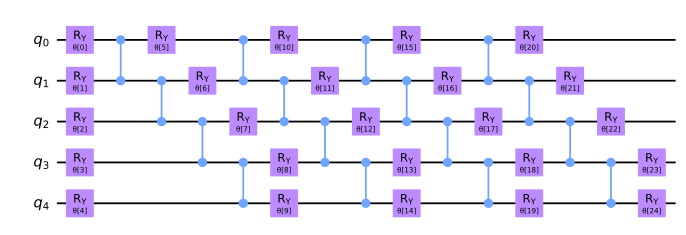

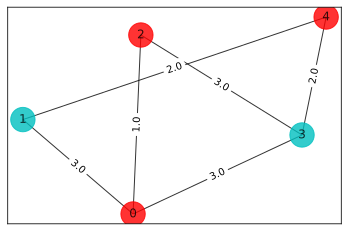

In [6]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=4, entanglement='linear')

vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

display(ry.draw(output='mpl',scale=0.9,justify="left"))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

2021-01-31 00:50:24,122:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[-5.40252093  1.6774766   2.72087723  3.71580282  4.77166266 -2.05018404
 -0.98370478  2.34170283 -4.26787638 -1.29679024  0.76195388 -2.44462127
 -1.72670521 -3.62883805  5.72774629  5.66170548  3.13935812  2.09612143
  1.24464     3.92592557 -5.90376444 -5.02560398 -3.99587479 -1.28319843
  1.65968458]
2021-01-31 00:50:24,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.36915669] - 7.96294 (ms), eval count: 1
2021-01-31 00:50:24,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-01-31 00:50:24,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.57660323] - 4.99797 (ms), eval count: 51
2021-01-31 00:50:24,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.03224406] - 6.00076 (ms), eval count: 52
2021-01-31 00:50:24,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.96131618] - 6.01244 (ms), eval count: 53
2021-01-31 00:50:24,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.99574974] - 7.01070 (ms), eval count: 54
2021-01-31 00:50:24,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.30959054] - 7.99584 (ms), eval count: 55
2021-01-31 00:50:24,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.37717277] - 7.99966 (ms), eval count: 56
2021-01-31 00:50:24,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-01-31 00:50:24,860:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.75673155] - 3.99733 (ms), eval count: 106
2021-01-31 00:50:24,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.01566584] - 5.99241 (ms), eval count: 107
2021-01-31 00:50:24,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.85872671] - 3.99423 (ms), eval count: 108
2021-01-31 00:50:24,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.86006834] - 5.95832 (ms), eval count: 109
2021-01-31 00:50:24,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.95343723] - 5.00655 (ms), eval count: 110
2021-01-31 00:50:24,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.57337598] - 3.99828 (ms), eval count: 111
2021-01-31 00:50:24,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:25,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.72258277] - 4.03595 (ms), eval count: 160
2021-01-31 00:50:25,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.98668013] - 5.02086 (ms), eval count: 161
2021-01-31 00:50:25,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.80056397] - 5.99766 (ms), eval count: 162
2021-01-31 00:50:25,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.0477434] - 5.99122 (ms), eval count: 163
2021-01-31 00:50:25,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78702363] - 7.00116 (ms), eval count: 164
2021-01-31 00:50:25,230:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.80080297] - 6.05297 (ms), eval count: 165
2021-01-31 00:50:25,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-31 00:50:25,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53906488] - 5.02801 (ms), eval count: 214
2021-01-31 00:50:25,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41646479] - 7.00045 (ms), eval count: 215
2021-01-31 00:50:25,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.47748661] - 5.02896 (ms), eval count: 216
2021-01-31 00:50:25,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.33858272] - 3.99971 (ms), eval count: 217
2021-01-31 00:50:25,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.45608608] - 5.99861 (ms), eval count: 218
2021-01-31 00:50:25,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37379748] - 6.00052 (ms), eval count: 219
2021-01-31 00:50:25,618:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:25,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57414964] - 6.00481 (ms), eval count: 268
2021-01-31 00:50:25,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53175121] - 6.00052 (ms), eval count: 269
2021-01-31 00:50:25,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5487015] - 5.03373 (ms), eval count: 270
2021-01-31 00:50:25,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70770101] - 5.03111 (ms), eval count: 271
2021-01-31 00:50:25,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57594535] - 5.03397 (ms), eval count: 272
2021-01-31 00:50:25,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55670204] - 5.00083 (ms), eval count: 273
2021-01-31 00:50:26,000:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-31 00:50:26,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.68672726] - 6.04868 (ms), eval count: 322
2021-01-31 00:50:26,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.58891508] - 5.00107 (ms), eval count: 323
2021-01-31 00:50:26,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.66893794] - 5.99432 (ms), eval count: 324
2021-01-31 00:50:26,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54138989] - 6.02984 (ms), eval count: 325
2021-01-31 00:50:26,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62827281] - 5.00011 (ms), eval count: 326
2021-01-31 00:50:26,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77163143] - 4.95791 (ms), eval count: 327
2021-01-31 00:50:26,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:26,663:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7294748] - 5.00011 (ms), eval count: 376
2021-01-31 00:50:26,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77707211] - 4.03428 (ms), eval count: 377
2021-01-31 00:50:26,676:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76783368] - 5.03755 (ms), eval count: 378
2021-01-31 00:50:26,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7036663] - 5.02992 (ms), eval count: 379
2021-01-31 00:50:26,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81810195] - 5.03969 (ms), eval count: 380
2021-01-31 00:50:26,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74320848] - 5.03063 (ms), eval count: 381
2021-01-31 00:50:26,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-31 00:50:27,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81367698] - 5.99456 (ms), eval count: 430
2021-01-31 00:50:27,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70433458] - 4.03476 (ms), eval count: 431
2021-01-31 00:50:27,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77320455] - 5.99957 (ms), eval count: 432
2021-01-31 00:50:27,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.75164679] - 6.00100 (ms), eval count: 433
2021-01-31 00:50:27,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77561445] - 7.00140 (ms), eval count: 434
2021-01-31 00:50:27,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.73528816] - 7.00164 (ms), eval count: 435
2021-01-31 00:50:27,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:27,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84335909] - 5.02896 (ms), eval count: 484
2021-01-31 00:50:27,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69013381] - 6.00100 (ms), eval count: 485
2021-01-31 00:50:27,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72195881] - 5.02849 (ms), eval count: 486
2021-01-31 00:50:27,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90554396] - 6.00600 (ms), eval count: 487
2021-01-31 00:50:27,420:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80162895] - 5.00226 (ms), eval count: 488
2021-01-31 00:50:27,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85833898] - 4.03023 (ms), eval count: 489
2021-01-31 00:50:27,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:27,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78925017] - 5.00035 (ms), eval count: 538
2021-01-31 00:50:27,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80594306] - 5.00131 (ms), eval count: 539
2021-01-31 00:50:27,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80477426] - 4.03929 (ms), eval count: 540
2021-01-31 00:50:27,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83184716] - 6.99949 (ms), eval count: 541
2021-01-31 00:50:27,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80070475] - 4.04096 (ms), eval count: 542
2021-01-31 00:50:27,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85181112] - 5.00345 (ms), eval count: 543
2021-01-31 00:50:27,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-31 00:50:28,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87747925] - 5.99504 (ms), eval count: 592
2021-01-31 00:50:28,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84199482] - 4.00066 (ms), eval count: 593
2021-01-31 00:50:28,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8229946] - 6.00243 (ms), eval count: 594
2021-01-31 00:50:28,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81166541] - 4.99487 (ms), eval count: 595
2021-01-31 00:50:28,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79621408] - 6.00028 (ms), eval count: 596
2021-01-31 00:50:28,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83048057] - 5.03063 (ms), eval count: 597
2021-01-31 00:50:28,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-31 00:50:28,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90143994] - 5.97286 (ms), eval count: 646
2021-01-31 00:50:28,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88909779] - 5.00083 (ms), eval count: 647
2021-01-31 00:50:28,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84011132] - 5.99980 (ms), eval count: 648
2021-01-31 00:50:28,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86994265] - 4.00066 (ms), eval count: 649
2021-01-31 00:50:28,449:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88200811] - 7.00092 (ms), eval count: 650
2021-01-31 00:50:28,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95019544] - 5.04088 (ms), eval count: 651
2021-01-31 00:50:28,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimizat

optimal function value: -13.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


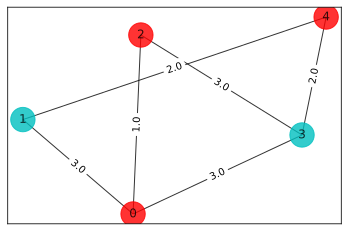

In [7]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
#qp.to_docplex().prettyprint()

# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

---